# 2. Import libraries and read data

In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [2]:
from joblib import Parallel, delayed
from joblib import parallel_backend

In [3]:
df = pd.read_csv("data_resampled_50.csv")

### 4.1.3 Cross Vallidation

In [4]:
majority_class = df[df['Outcome'] == 0]
minority_class = df[df['Outcome'] == 1]

# Define the number of samples to select
n_samples = 50

# Perform random sampling
sampled_majority = majority_class.sample(n_samples, random_state=123)
sampled_minority = minority_class.sample(n_samples, random_state=123)

# Combine sampled data
sampled_df = pd.concat([sampled_majority, sampled_minority])
sampled_df

#test
y_test = sampled_df['Outcome']
x_test = sampled_df.drop(columns='Outcome')

# train
# Separate remaining data for training
remaining_df = df.drop(sampled_df.index)
y_train = remaining_df['Outcome']
x_train= remaining_df.drop(columns='Outcome')

scaler = StandardScaler()
scaler.fit(x_train)

x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

In [5]:
#from sklearn.model_selection import RepeatedKFold
rs=123
cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=345)

## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [6]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [7]:
# Creating and running our optimization
study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
study_knn.optimize(objective_knn, n_trials=100)

[I 2024-08-26 01:02:46,839] A new study created in memory with name: KNN
[I 2024-08-26 01:02:47,116] Trial 0 finished with value: 0.7747828142025859 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'metric': 'euclidean', 'p': 17, 'algorithm': 'brute', 'leaf_size': 66}. Best is trial 0 with value: 0.7747828142025859.
[I 2024-08-26 01:02:47,263] Trial 1 finished with value: 0.7991381611867817 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean', 'p': 7, 'algorithm': 'ball_tree', 'leaf_size': 89}. Best is trial 1 with value: 0.7991381611867817.
[I 2024-08-26 01:02:47,367] Trial 2 finished with value: 0.8369164872983431 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'ball_tree', 'leaf_size': 61}. Best is trial 2 with value: 0.8369164872983431.
[I 2024-08-26 01:02:47,705] Trial 3 finished with value: 0.7061497861643751 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'minkowski',

[I 2024-08-26 01:02:53,445] Trial 32 finished with value: 0.8426161375418688 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 1}. Best is trial 17 with value: 0.8460916644991693.
[I 2024-08-26 01:02:53,576] Trial 33 finished with value: 0.8345274093858897 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'kd_tree', 'leaf_size': 13}. Best is trial 17 with value: 0.8460916644991693.
[I 2024-08-26 01:02:53,694] Trial 34 finished with value: 0.8404659010024039 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'kd_tree', 'leaf_size': 83}. Best is trial 17 with value: 0.8460916644991693.
[I 2024-08-26 01:02:53,817] Trial 35 finished with value: 0.8382566514665432 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'kd_tree', 'leaf_size': 57}. Best is trial 1

[I 2024-08-26 01:02:59,365] Trial 64 finished with value: 0.8086591398404416 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'ball_tree', 'leaf_size': 44}. Best is trial 41 with value: 0.8510438735581765.
[I 2024-08-26 01:02:59,497] Trial 65 finished with value: 0.8445853121928437 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'ball_tree', 'leaf_size': 60}. Best is trial 41 with value: 0.8510438735581765.
[I 2024-08-26 01:02:59,628] Trial 66 finished with value: 0.8392281622023056 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'kd_tree', 'leaf_size': 18}. Best is trial 41 with value: 0.8510438735581765.
[I 2024-08-26 01:02:59,760] Trial 67 finished with value: 0.8422527742277325 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'auto', 'leaf_size': 35}. Best is trial

[I 2024-08-26 01:03:04,379] Trial 96 finished with value: 0.844313555302492 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 14}. Best is trial 41 with value: 0.8510438735581765.
[I 2024-08-26 01:03:04,489] Trial 97 finished with value: 0.8277776207257008 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'ball_tree', 'leaf_size': 26}. Best is trial 41 with value: 0.8510438735581765.
[I 2024-08-26 01:03:04,644] Trial 98 finished with value: 0.780341401557558 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'manhattan', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 21}. Best is trial 41 with value: 0.8510438735581765.
[I 2024-08-26 01:03:04,772] Trial 99 finished with value: 0.8460916644991693 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'auto', 'leaf_size': 12}. Best is trial 41 wi

In [8]:
# Evaluating our Optuna Trial
print("Best trial:", study_knn.best_trial.number)
print("Best accuracy:", study_knn.best_trial.value)
print("Best hyperparameters:", study_knn.best_params)

Best trial: 41
Best accuracy: 0.8510438735581765
Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 45, 'algorithm': 'kd_tree', 'leaf_size': 14}


              precision    recall  f1-score   support

           0     0.7667    0.9200    0.8364        50
           1     0.9000    0.7200    0.8000        50

    accuracy                         0.8200       100
   macro avg     0.8333    0.8200    0.8182       100
weighted avg     0.8333    0.8200    0.8182       100



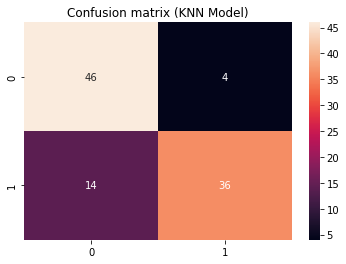

In [36]:
best_param_knn = study_knn.best_params
KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
y_pred_knn = KNN.predict(x_test_)

def display_results(y_test, y_pred, cm_title):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
    print(classification_report(y_test,y_pred, digits=4))
    
    
display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

Accuracy: 0.8200
Precision: 0.9000
Recall: 0.7200
F1 Score: 0.8000

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



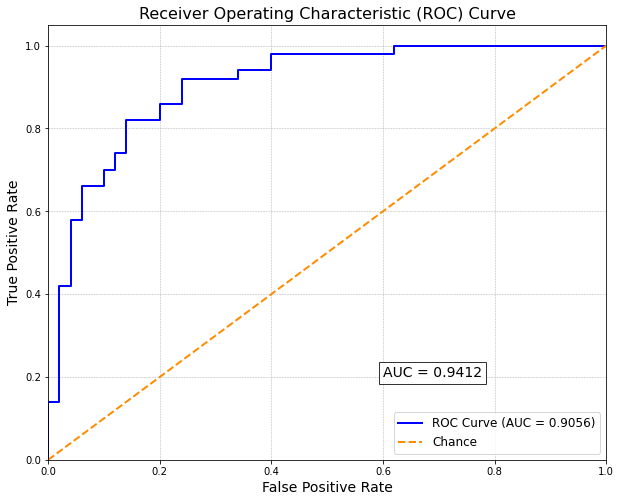

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, classification_report

# Get the best parameters from the Optuna study and train the KNN model
best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(x_train_, y_train)

# Predict on the test set
y_pred = best_knn.predict(x_test_)
y_proba = best_knn.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_knn:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()


## 4.3 Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [12]:
# Creating and running our optimization

study_lr = optuna.create_study(direction='maximize',study_name = "logr")
study_lr.optimize(objective_lr, n_trials=100)

[I 2024-08-26 01:03:05,068] A new study created in memory with name: logr
[I 2024-08-26 01:03:05,242] Trial 0 finished with value: 0.7152744030510705 and parameters: {'C': 0.02828796301045505, 'solver': 'liblinear', 'max_iter': 473}. Best is trial 0 with value: 0.7152744030510705.
[I 2024-08-26 01:03:07,642] Trial 1 finished with value: 0.7965226989627587 and parameters: {'C': 0.5456460627483642, 'solver': 'lbfgs', 'max_iter': 666}. Best is trial 1 with value: 0.7965226989627587.
[I 2024-08-26 01:03:09,917] Trial 2 finished with value: 0.7087974429259755 and parameters: {'C': 1.777518941417547, 'solver': 'sag', 'max_iter': 903}. Best is trial 1 with value: 0.7965226989627587.
[I 2024-08-26 01:03:12,177] Trial 3 finished with value: 0.7920800785204887 and parameters: {'C': 0.0020416695458489835, 'solver': 'lbfgs', 'max_iter': 479}. Best is trial 1 with value: 0.7965226989627587.
[I 2024-08-26 01:03:13,962] Trial 4 finished with value: 0.7029767425208733 and parameters: {'C': 0.029428821

[I 2024-08-26 01:05:07,694] Trial 40 finished with value: 0.7969975216898504 and parameters: {'C': 1.5022422819560008, 'solver': 'lbfgs', 'max_iter': 838}. Best is trial 28 with value: 0.7973471414832904.
[I 2024-08-26 01:05:09,824] Trial 41 finished with value: 0.7966750068972149 and parameters: {'C': 1.72307094308533, 'solver': 'lbfgs', 'max_iter': 826}. Best is trial 28 with value: 0.7973471414832904.
[I 2024-08-26 01:05:13,525] Trial 42 finished with value: 0.7962012918297927 and parameters: {'C': 1.779293960567302, 'solver': 'lbfgs', 'max_iter': 845}. Best is trial 28 with value: 0.7973471414832904.
[I 2024-08-26 01:05:16,778] Trial 43 finished with value: 0.7958055257863964 and parameters: {'C': 2.8132193383680235, 'solver': 'lbfgs', 'max_iter': 906}. Best is trial 28 with value: 0.7973471414832904.
[I 2024-08-26 01:05:16,984] Trial 44 finished with value: 0.7908008771398969 and parameters: {'C': 1.5508206853962732, 'solver': 'liblinear', 'max_iter': 840}. Best is trial 28 with v

[I 2024-08-26 01:07:01,459] Trial 80 finished with value: 0.7973471414832904 and parameters: {'C': 1.4324750571194356, 'solver': 'lbfgs', 'max_iter': 831}. Best is trial 28 with value: 0.7973471414832904.
[I 2024-08-26 01:07:12,679] Trial 81 finished with value: 0.7962012918297927 and parameters: {'C': 2.069859957222573, 'solver': 'lbfgs', 'max_iter': 795}. Best is trial 28 with value: 0.7973471414832904.
[I 2024-08-26 01:07:26,488] Trial 82 finished with value: 0.7973471414832904 and parameters: {'C': 1.379125118564509, 'solver': 'lbfgs', 'max_iter': 827}. Best is trial 28 with value: 0.7973471414832904.
[I 2024-08-26 01:07:39,694] Trial 83 finished with value: 0.7973471414832904 and parameters: {'C': 1.474389650514448, 'solver': 'lbfgs', 'max_iter': 827}. Best is trial 28 with value: 0.7973471414832904.
[I 2024-08-26 01:07:53,065] Trial 84 finished with value: 0.7969975216898504 and parameters: {'C': 1.5216204445641475, 'solver': 'lbfgs', 'max_iter': 843}. Best is trial 28 with value

In [13]:
# Evaluating our Optuna Trial
print("Best trial:", study_lr.best_trial.number)
print("Best accuracy:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_params)

Best trial: 28
Best accuracy: 0.7973471414832904
Best hyperparameters: {'C': 1.4686719051200745, 'solver': 'lbfgs', 'max_iter': 326}


              precision    recall  f1-score   support

           0     0.7121    0.9400    0.8103        50
           1     0.9118    0.6200    0.7381        50

    accuracy                         0.7800       100
   macro avg     0.8119    0.7800    0.7742       100
weighted avg     0.8119    0.7800    0.7742       100



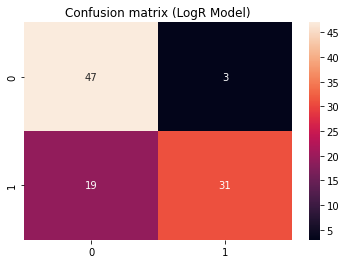

In [40]:
best_param_logr = study_lr.best_params
LR = LogisticRegression(**best_param_logr).fit(x_train_,y_train)
y_pred_lr = LR.predict(x_test_)
    
display_results(y_test, y_pred_lr,cm_title = "Confusion matrix (LogR Model)")

Accuracy: 0.7800
Precision: 0.9118
Recall: 0.6200
F1 Score: 0.7381

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



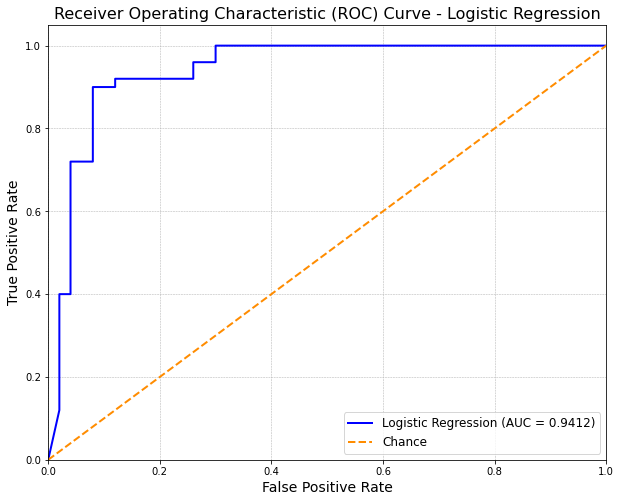

In [75]:
# Predict on the test set
y_pred_lr = LR.predict(x_test_)
y_proba_lr = LR.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot the ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.4 Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [17]:
# Creating and running our optimization

study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
study_dect.optimize(objective_dect, n_trials=100)

[I 2024-08-26 01:10:33,533] A new study created in memory with name: Dect
[I 2024-08-26 01:10:33,667] Trial 0 finished with value: 0.3048017607529284 and parameters: {'max_depth': 18, 'ccp_alpha': 1.2397461400510623, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 0 with value: 0.3048017607529284.
[I 2024-08-26 01:10:33,801] Trial 1 finished with value: 0.3048017607529284 and parameters: {'max_depth': 43, 'ccp_alpha': 0.333566180665239, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.3048017607529284.
[I 2024-08-26 01:10:33,927] Trial 2 finished with value: 0.5306987732595791 and parameters: {'max_depth': 12, 'ccp_alpha': 0.40123285930223185, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 2 with value: 0.5306987732595791.
[I 2024-08-26 01:10:34,051] Trial 3 finished with value: 0.82559

[I 2024-08-26 01:10:37,545] Trial 29 finished with value: 0.8102058359056543 and parameters: {'max_depth': 16, 'ccp_alpha': 0.002098644268655809, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 26 with value: 0.8540786173873168.
[I 2024-08-26 01:10:37,687] Trial 30 finished with value: 0.8524648438686642 and parameters: {'max_depth': 8, 'ccp_alpha': 0.0016350054441380414, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 26 with value: 0.8540786173873168.
[I 2024-08-26 01:10:37,827] Trial 31 finished with value: 0.849986271971611 and parameters: {'max_depth': 7, 'ccp_alpha': 0.001530901620850231, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 26 with value: 0.8540786173873168.
[I 2024-08-26 01:10:37,964] Trial 32 finished with value: 0.8494758185515345 and parameters: {'max_depth': 15, 'ccp_alpha': 0.0040392

[I 2024-08-26 01:10:41,668] Trial 58 finished with value: 0.8027284641635392 and parameters: {'max_depth': 32, 'ccp_alpha': 0.010191733685159169, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 26 with value: 0.8540786173873168.
[I 2024-08-26 01:10:41,842] Trial 59 finished with value: 0.8549644791205587 and parameters: {'max_depth': 36, 'ccp_alpha': 0.0036791062017749654, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 59 with value: 0.8549644791205587.
[I 2024-08-26 01:10:41,988] Trial 60 finished with value: 0.8469360050185374 and parameters: {'max_depth': 40, 'ccp_alpha': 0.003116326870603139, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 59 with value: 0.8549644791205587.
[I 2024-08-26 01:10:42,133] Trial 61 finished with value: 0.8553151438878901 and parameters: {'max_depth': 34, 'ccp_alpha'

[I 2024-08-26 01:10:45,939] Trial 87 finished with value: 0.8517516989056372 and parameters: {'max_depth': 31, 'ccp_alpha': 0.004858825798251839, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8571742541259426.
[I 2024-08-26 01:10:46,083] Trial 88 finished with value: 0.8410863917809165 and parameters: {'max_depth': 23, 'ccp_alpha': 0.016620296675369572, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8571742541259426.
[I 2024-08-26 01:10:46,230] Trial 89 finished with value: 0.851317584675237 and parameters: {'max_depth': 27, 'ccp_alpha': 0.0016293282808257726, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 62 with value: 0.8571742541259426.
[I 2024-08-26 01:10:46,372] Trial 90 finished with value: 0.8242091834394418 and parameters: {'max_depth': 33, 'ccp_alpha'

In [18]:
# Evaluating our Optuna Trial
print("Best trial:", study_dect.best_trial.number)
print("Best accuracy:", study_dect.best_trial.value)
print("Best hyperparameters:", study_dect.best_params)

Best trial: 62
Best accuracy: 0.8571742541259426
Best hyperparameters: {'max_depth': 35, 'ccp_alpha': 0.0010091531649584669, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 8, 'criterion': 'entropy'}


              precision    recall  f1-score   support

           0     0.8431    0.8600    0.8515        50
           1     0.8571    0.8400    0.8485        50

    accuracy                         0.8500       100
   macro avg     0.8501    0.8500    0.8500       100
weighted avg     0.8501    0.8500    0.8500       100



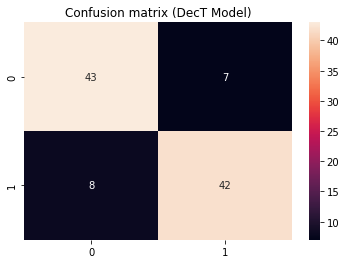

In [41]:
best_param_dect = study_dect.best_params
DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
y_pred_dect = DecT.predict(x_test)
    

display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")

Accuracy: 0.7800
Precision: 0.8333
Recall: 0.7000
F1 Score: 0.7609

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        50
           1       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100



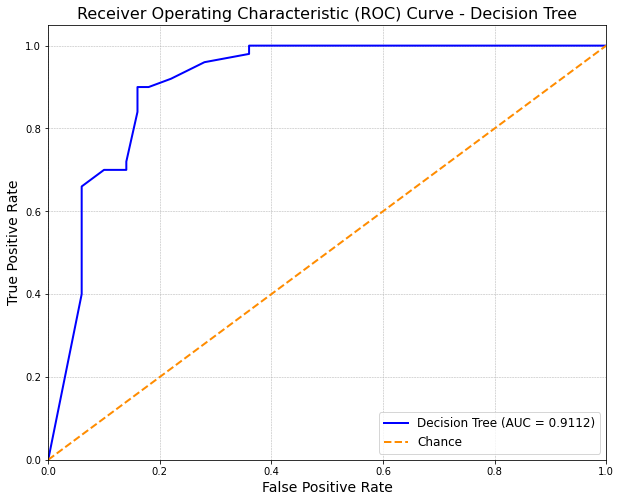

In [20]:
# Train the best Decision Tree model
best_param_dect = study_dect.best_params
best_dect = DecisionTreeClassifier(**best_param_dect, random_state=123)
best_dect.fit(x_train_, y_train)

# Predict on the test set
y_pred_dect = best_dect.predict(x_test_)
y_proba_dect = best_dect.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_dect = accuracy_score(y_test, y_pred_dect)
precision_dect = precision_score(y_test, y_pred_dect)
recall_dect = recall_score(y_test, y_pred_dect)
f1_dect = f1_score(y_test, y_pred_dect)

print(f"Accuracy: {accuracy_dect:.4f}")
print(f"Precision: {precision_dect:.4f}")
print(f"Recall: {recall_dect:.4f}")
print(f"F1 Score: {f1_dect:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dect))

# Plot the ROC curve
fpr_dect, tpr_dect, _ = roc_curve(y_test, y_proba_dect)
roc_auc_dect = auc(fpr_dect, tpr_dect)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dect, tpr_dect, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.5 SVM (Support Vector Machine)

In [21]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [22]:
# Creating and running our optimization

study_svm = optuna.create_study(direction='maximize',study_name ="SVM")
study_svm.optimize(objective_svm, n_trials=100)

[I 2024-08-26 01:10:47,878] A new study created in memory with name: SVM
[I 2024-08-26 01:10:48,994] Trial 0 finished with value: 0.3048017607529284 and parameters: {'C': 0.002349031709601799, 'gamma': 0.17719489199382207}. Best is trial 0 with value: 0.3048017607529284.
[I 2024-08-26 01:10:50,106] Trial 1 finished with value: 0.3048017607529284 and parameters: {'C': 0.04633427169678509, 'gamma': 8.126649596004959e-05}. Best is trial 0 with value: 0.3048017607529284.
[I 2024-08-26 01:10:51,211] Trial 2 finished with value: 0.3048017607529284 and parameters: {'C': 0.08048681091406489, 'gamma': 1.1975355732533658e-05}. Best is trial 0 with value: 0.3048017607529284.
[I 2024-08-26 01:10:52,310] Trial 3 finished with value: 0.3048017607529284 and parameters: {'C': 0.0013230507928548916, 'gamma': 0.036157003544567225}. Best is trial 0 with value: 0.3048017607529284.
[I 2024-08-26 01:10:53,414] Trial 4 finished with value: 0.3048017607529284 and parameters: {'C': 0.0012459617962100721, 'gamm

[I 2024-08-26 01:11:27,983] Trial 41 finished with value: 0.8362118030317868 and parameters: {'C': 2.622405395812238, 'gamma': 0.026591422288789444}. Best is trial 20 with value: 0.8412643514740655.
[I 2024-08-26 01:11:28,558] Trial 42 finished with value: 0.8317620398814489 and parameters: {'C': 0.5933110174782295, 'gamma': 0.1144459166640013}. Best is trial 20 with value: 0.8412643514740655.
[I 2024-08-26 01:11:29,259] Trial 43 finished with value: 0.8092571478376186 and parameters: {'C': 12.811146314516199, 'gamma': 0.29029857249293756}. Best is trial 20 with value: 0.8412643514740655.
[I 2024-08-26 01:11:29,860] Trial 44 finished with value: 0.8272054605244986 and parameters: {'C': 4.643080067545609, 'gamma': 0.007970273987456767}. Best is trial 20 with value: 0.8412643514740655.
[I 2024-08-26 01:11:30,526] Trial 45 finished with value: 0.8043141558588099 and parameters: {'C': 1.2782016802746978, 'gamma': 0.002752616314913677}. Best is trial 20 with value: 0.8412643514740655.
[I 20

[I 2024-08-26 01:11:57,038] Trial 83 finished with value: 0.834763259373077 and parameters: {'C': 1.2836968310864327, 'gamma': 0.0621735955885794}. Best is trial 55 with value: 0.8438667873591692.
[I 2024-08-26 01:11:57,621] Trial 84 finished with value: 0.8307645197685318 and parameters: {'C': 0.5999327026938915, 'gamma': 0.11932523052324417}. Best is trial 55 with value: 0.8438667873591692.
[I 2024-08-26 01:11:58,276] Trial 85 finished with value: 0.8228218640787159 and parameters: {'C': 0.15387817536165418, 'gamma': 0.03567469158132533}. Best is trial 55 with value: 0.8438667873591692.
[I 2024-08-26 01:11:59,214] Trial 86 finished with value: 0.8166397653688517 and parameters: {'C': 48.13707674037539, 'gamma': 0.4047882809736685}. Best is trial 55 with value: 0.8438667873591692.
[I 2024-08-26 01:11:59,842] Trial 87 finished with value: 0.8251637036544243 and parameters: {'C': 0.33913976245430905, 'gamma': 0.02317039939204469}. Best is trial 55 with value: 0.8438667873591692.
[I 2024

In [23]:
# Evaluating our Optuna Trial
print("Best trial:", study_svm.best_trial.number)
print("Best accuracy:", study_svm.best_trial.value)
print("Best hyperparameters:", study_svm.best_params)

Best trial: 55
Best accuracy: 0.8438667873591692
Best hyperparameters: {'C': 5.571758435156035, 'gamma': 0.05373860851989882}


              precision    recall  f1-score   support

           0     0.7895    0.9000    0.8411        50
           1     0.8837    0.7600    0.8172        50

    accuracy                         0.8300       100
   macro avg     0.8366    0.8300    0.8292       100
weighted avg     0.8366    0.8300    0.8292       100



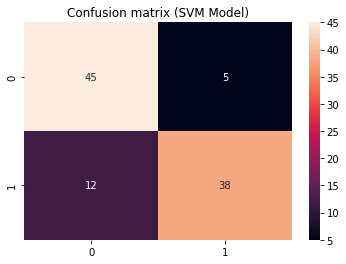

In [42]:
best_param_svm = study_svm.best_params
SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
y_pred_svm = SVM.predict(x_test_)

display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.8300
Precision: 0.8837
Recall: 0.7600
F1 Score: 0.8172

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



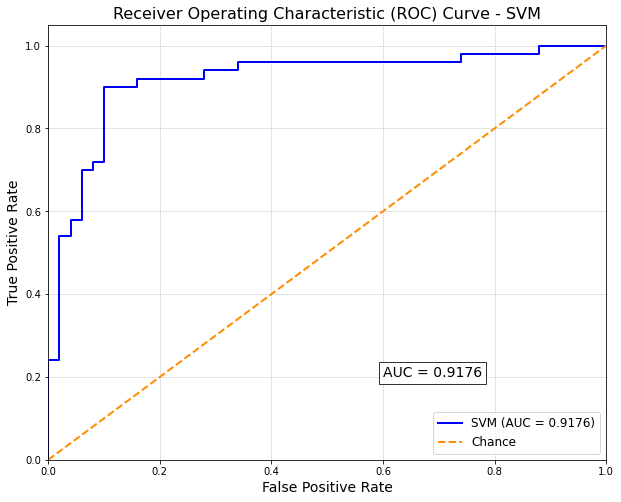

In [25]:
# Train the best SVM model
best_param_svm = study_svm.best_params
best_svm = SVC(**best_param_svm, random_state=123, probability=True)
best_svm.fit(x_train_, y_train)

# Predict on the test set
y_pred_svm = best_svm.predict(x_test_)
y_proba_svm = best_svm.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot the ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_svm:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

## Xgboost

In [26]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


In [27]:
pos_weight = y_train.sum() / (len(y_train) - y_train.sum())
pos_weight

0.411214953271028

In [28]:
# Creating and running our optimization
study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")

with parallel_backend('threading'):
    study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=-1)

[I 2024-08-26 01:12:15,801] A new study created in memory with name: XGBoost
[I 2024-08-26 01:13:43,290] Trial 4 finished with value: 0.8765621989643475 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7494521240316852, 'colsample_bytree': 0.6154037302618618, 'reg_alpha': 1.8756297543035208e-05, 'reg_lambda': 7.145289143353638e-05}. Best is trial 4 with value: 0.8765621989643475.
[I 2024-08-26 01:13:48,957] Trial 2 finished with value: 0.8831984926198793 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9161053741158192, 'colsample_bytree': 0.9491068209937872, 'reg_alpha': 0.0005292800201333621, 'reg_lambda': 1.958175475418391e-05}. Best is trial 2 with value: 0.8831984926198793.
[I 2024-08-26 01:13:53,934] Trial 7 finished with value: 0.8751210086396841 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.6451769355580075, 'colsample_bytree': 0.8225870726743674, 'reg_alpha': 0.0006703682573961478, 'reg_lambda': 0.0269611466

In [29]:
# Evaluating our Optuna Trial
print("Best trial:", study_xgb.best_trial.number)
print("Best accuracy:", study_xgb.best_trial.value)
print("Best hyperparameters:", study_xgb.best_params)


Best trial: 11
Best accuracy: 0.887261844595285
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9487500581235251, 'colsample_bytree': 0.7300536297256703, 'reg_alpha': 0.00024929496041591656, 'reg_lambda': 0.00011695554723639851}


              precision    recall  f1-score   support

           0     0.8148    0.8800    0.8462        50
           1     0.8696    0.8000    0.8333        50

    accuracy                         0.8400       100
   macro avg     0.8422    0.8400    0.8397       100
weighted avg     0.8422    0.8400    0.8397       100



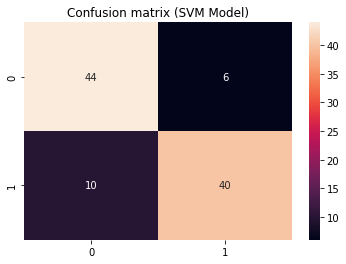

In [44]:
# Train the best XGBoost model
best_param_xgb = study_xgb.best_params
best_xgb = xgb.XGBClassifier(**best_param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
xgb=best_xgb.fit(x_train_, y_train)
y_pred_xgb = xgb.predict(x_test_)

display_results(y_test, y_pred_xgb, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.8400
Precision: 0.8696
Recall: 0.8000
F1 Score: 0.8333

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



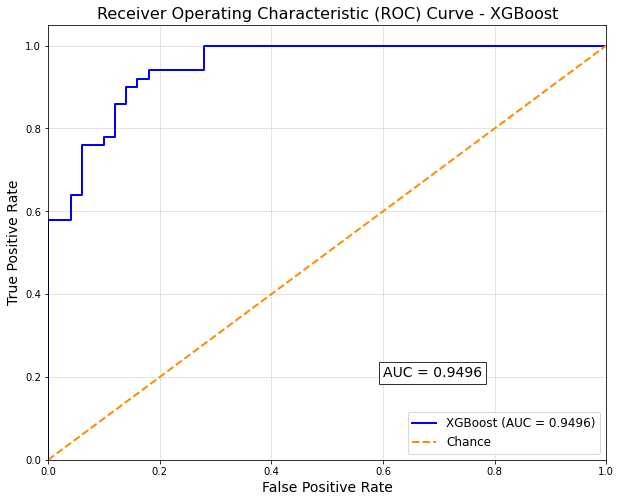

In [43]:
# Predict on the test set
y_pred_xgb = best_xgb.predict(x_test_)
y_proba_xgb = best_xgb.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Plot the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_xgb:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

# 5. Models Comparison

The ROC-Curve plot provides us with a clear view to choose the best model, as it is evident that the decision tree model has the largest area under the curve. Therefore, based on the ROC , the decision tree model is selected as the best model.

In [76]:
# Create a dictionary to store the metrics for each model
metrics_summary = {
    "Model": ["KNN", "SVM", "LR", "DecT", "XGB"],
    "Accuracy": [accuracy_knn, accuracy_svm, accuracy_lr, accuracy_dect, accuracy_xgb],
    "Recall": [recall_knn, recall_svm, recall_lr, recall_dect, recall_xgb],
    "Precision": [precision_knn, precision_svm, precision_lr, precision_dect, precision_xgb],
    "F1-Score": [f1_knn, f1_svm, f1_lr, f1_dect, f1_xgb],
    "AUC": [roc_auc_lr, roc_auc_svm, roc_auc_knn, roc_auc_dect, roc_auc_xgb]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the DataFrame
metrics_df


,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,KNN,0.82,0.72,0.900000,0.800000,0.9056
1,SVM,0.83,0.76,0.883721,0.817204,0.9176
2,LR,0.78,0.62,0.911765,0.738095,0.9412
3,DecT,0.78,0.70,0.833333,0.760870,0.9112
4,XGB,0.84,0.80,0.869565,0.833333,0.9496


In [77]:
import os
metrics_df.to_excel('result/50.xlsx', index=False)

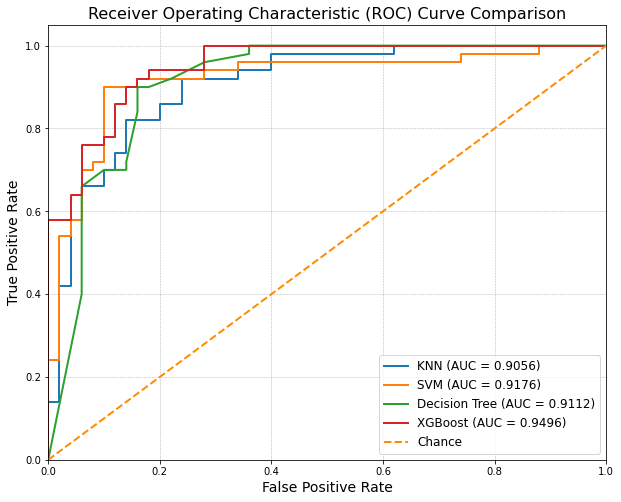

In [72]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for KNN
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'KNN (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')

# Plot ROC curve for Logistic Regression
#plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for Decision Tree
plt.plot(fpr_dect, tpr_dect, lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.show()
